# realizar el computo de la media del diametro por muestra individual con NEW DISTANCE TRANSFORM

In [36]:

from utils.new_distance_transform import new_distance_transform
from utils.test_utils import *
import os

# creando lista de paths de micrografias binarizadas
folder_path = 'data/ofda/images'

img_path_list = []
for filename in os.listdir(folder_path):
    img_path = os.path.join(folder_path,filename)
    if os.path.isfile(img_path):
        img_path_list.append(img_path)
        
print(img_path_list)

['data/ofda/images/bin_0214.png', 'data/ofda/images/bin_0199.png', 'data/ofda/images/bin_0157.png', 'data/ofda/images/bin_0200.png', 'data/ofda/images/bin_0225.png']


In [37]:
print(img_path_list[0])


diameter_count = new_distance_transform(img_path_list[0])

mean = get_mean_diameter(diameter_count)

print(f'mean = {mean}')

data/ofda/images/bin_0214.png
mean = 5.593922651933702


# realizar el computo de la media del diametro por muestra individual con DIST

In [1]:
import matplotlib.pyplot as plt
import os
import cv2
from unet import UNet
from hednet import HedNet
from utils.test_utils import *
from utils.net_utils import *

0214.png
0157.png
0199.png
0200.png
0225.png
.ipynb_checkpoints


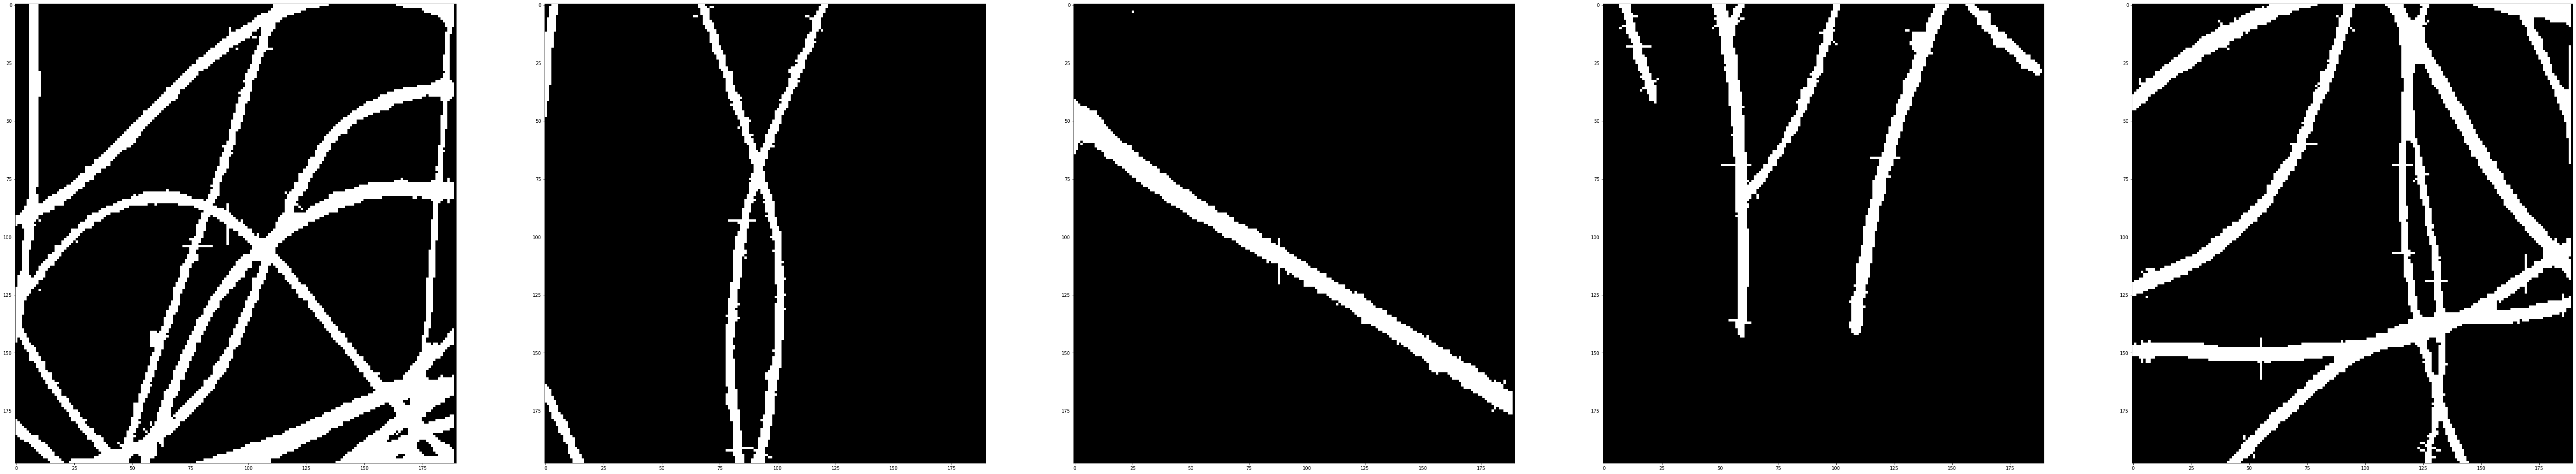

In [41]:
#tensor_batch = batch_from_folder('data/ofda/images')
folder_path = 'data/ofda/raw'
tensor_list = []

tf = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.114],std=[0.237])
                # transforms.Normalize(mean=[0.114, 0.114, 0.114],std=[0.237, 0.237, 0.237])
            ])

k=0
plt.figure(figsize=(100,20))
for filename in os.listdir(folder_path):
    img = cv2.imread(os.path.join(folder_path,filename), 0)
    print(filename)
    if img is not None:
        img = 255 - img
        _,img = cv2.threshold(img,128,255,cv2.THRESH_BINARY)
        #bg = img[:,:] < 128
        #img[bg] = 0
        
        plt.subplot(1,5,k+1), plt.imshow(img, cmap='gray')
        k += 1
        # pil_img = Image.open(os.path.join(folder_path,filename))
        pil_img = Image.fromarray(img)

        diffX = 256 - pil_img.size[0]            
        diffY = 256 - pil_img.size[1]
        pil_img = add_margin(pil_img, diffY // 2, diffX - diffX//2, diffY - diffY//2, diffX // 2, 0)

        tensor = tf(pil_img)
        tensor = tensor.expand(3, -1, -1)
        tensor_list.append(tensor)

tensor_batch = torch.cat([tensor.unsqueeze(0) for tensor in tensor_list])
#return tensor_batch
#########
plt.show()

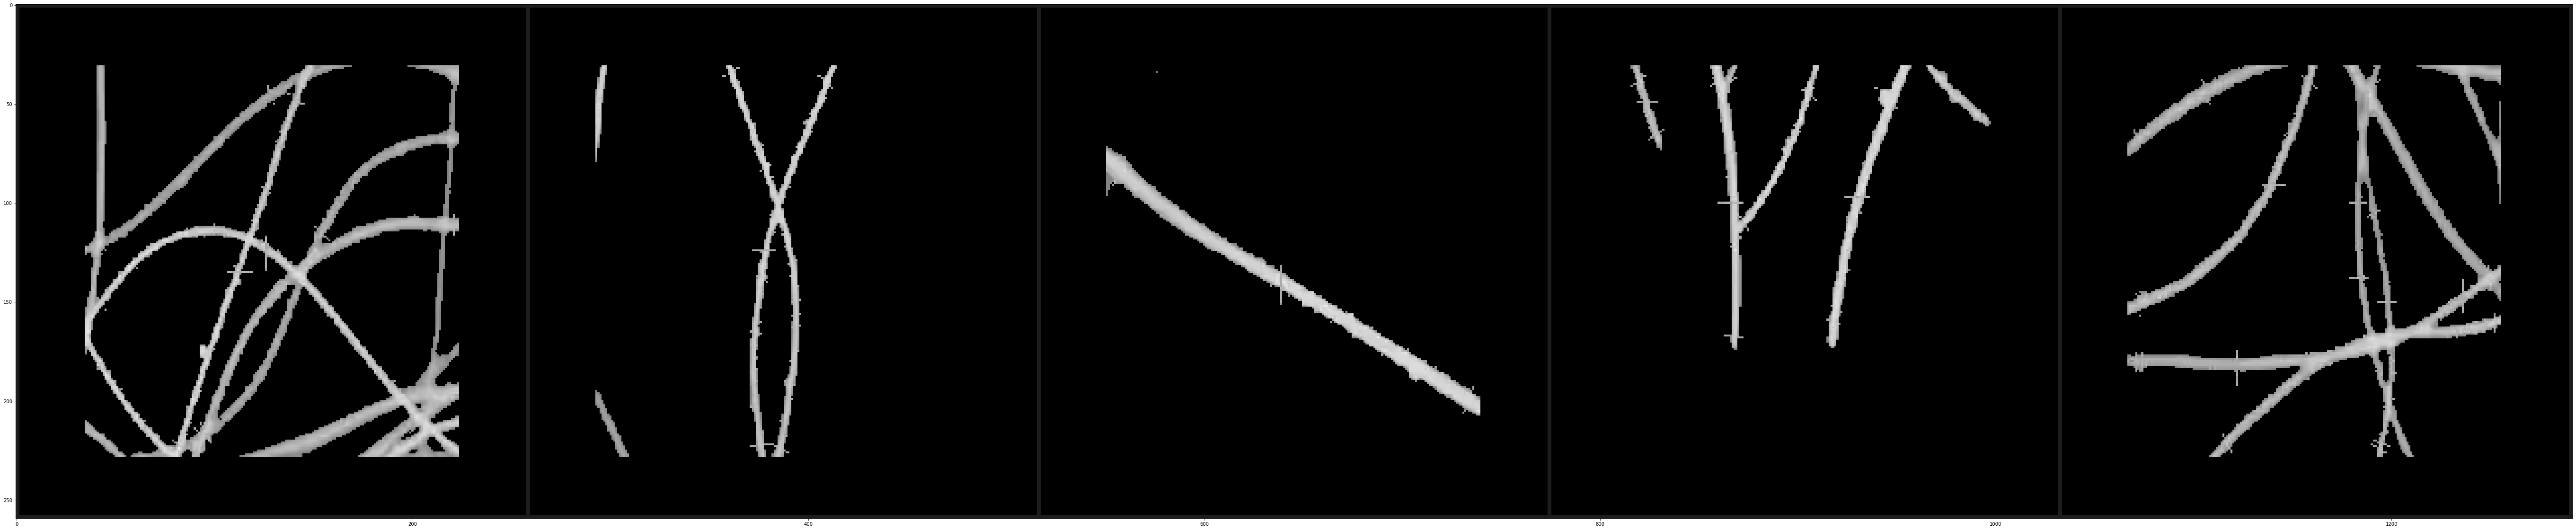

In [31]:
import torchvision

grid = torchvision.utils.make_grid(tensor_batch)

grid = grid.numpy().transpose((1,2,0))
mean = np.array([0.114])
std = np.array([0.237])
grid = std * grid + mean
grid = np.clip(grid, 0, 1)

#print(grid.shape)
plt.figure(figsize=(100,20))
plt.imshow(grid)
plt.show()

In [42]:
device = torch.device('cuda:2')

net = UNet(n_channels=3, n_classes=1, bilinear=False)

########
state_dict = torch.load('checkpoints/MODEL_dist_ours.pth', map_location=device)
from collections import OrderedDict
new_state_dict = OrderedDict()
for k,v in state_dict.items():
    name = k[7:]
    new_state_dict[name] = v
########

net.load_state_dict(new_state_dict)
net.to(device=device)
net.eval()


dm_list_unet = predict_dm_list(net, {'image':tensor_batch}, device)

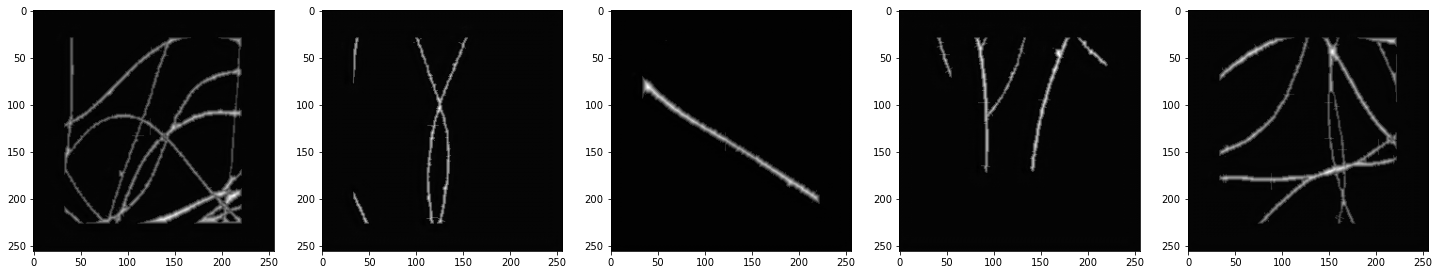

In [43]:
plt.figure(figsize=(5*5,5))

for i, dm in enumerate(dm_list_unet):
    plt.subplot(1,5,i+1), plt.imshow(dm, cmap='gray')
    
plt.show()

In [44]:
diameter_count = get_diameter_count(dm_list_unet[0])
diameter_mean = calc_diameter_mean(diameter_count)
print(diameter_mean)

4.017898832684825
